In [310]:
import networkx as nx
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from fa2 import ForceAtlas2
from community import community_louvain
import matplotlib.cm as cm
from collections import Counter
from IPython.core.display import display, HTML
from IPython.display import IFrame

In [279]:
charactersDf = pd.read_csv('characters.csv')
charactersDf.head()

,Unnamed: 0,Name
0,0,Aragorn II Elessar
1,1,Arwen
2,2,Frodo Baggins
3,3,Balin
4,4,Bilbo Baggins


In [280]:
pattern1 = '\[\[(.*?)(?:\|.*?)?\]\]'
# pattern2 = '\{\{(?:Term|Plural)\|BotW\|(.*?)(?:\|link)?\}\}'
gender = '(?:gender=\s)([a-zA-Z]*)(?:<.*?\/>)'
race = '(?:race=\s)\{\{Term\|BotW\|(.*?)\|link\}\}'
culture = '(?:Culture=\s)([a-zA-Z]*)(?:<.*?\/>)'


In [281]:
with open("txtfiles/" + charactersDf.Name[0] + '.txt',encoding='utf-8') as f:
    text = f.read()
print(text)

<br />{{Featured star}}
{{Disamb-two|son of Arathorn II|son of Aravir|[[Aragorn I]]}}
{{Disamb-more|Ranger of the North|[[Strider (disambiguation)]]}}
{{Infobox Person Men Dúnedain
| image = Aragorn profile.jpg
| caption = [[Viggo Mortensen]] portrays Aragorn in [[The Lord of the Rings film trilogy]]
| name = 
| othernames = Estel, Thorongil, Elessar (Edhelharn), Telcontar, Envinyatar, Strider, the Dúnadan, Wingfoot
| title = [[Chieftain of the Dúnedain]], [[Heir of Isildur|Heir]] of [[Isildur]]<br />[[King of all the Dúnedain|High]] [[King of the Reunited Kingdom|King]] of the [[Dúnedain]], [[Kings of Arnor|King]] of [[Arnor]], [[Kings of Gondor|King]] of [[Gondor]]
| birth = [[March 1]], [[TA 2931]]
| rule = [[TA 2933]] to [[TA 3019|3019]] (86 years as a Chieftain)<br />[[TA 3019]] to [[FO 120]] (122 years as a King)
| death = [[FO 120]] (aged 210)
| realms = [[Reunited Kingdom]] ([[Arnor]] and [[Gondor]])
| parentage = 
| spouse = [[Arwen|Arwen Undómiel]]
| children = [[Eldarion]] &

In [282]:
def nodeInfo(text):
    genderRe1 = re.findall(r'(?:gender=\s)([a-zA-Z]*)(?:<.*?\/>)',text)
    if genderRe1:
        if genderRe1[0] == '':
            gender = 'Unknown'
        else:
            gender = genderRe1[0]
    else:
        gender = 'Unknown'
    raceRe2 = re.findall(r'(?i)(?:race\s*=\s*)\[\[(.*?)(?:\|.*?)?\]\]',text)

    if raceRe2:
        race = raceRe2[0] 
    else:
        race = 'Unknown'

    cultureRe1 = re.findall(r'(?i)(?:culture\s*=[^\S\n]*)(.*)(?:\||\n)',text)
    if cultureRe1:
        cultureRe2 = re.findall(r'\[\[(.*?)(?:\|.*?)?\]\]',cultureRe1[0])
        culture = cultureRe2
    else:
        culture = ['Unkown']

    pattern1 = '\[\[(.*?)(?:\|.*?)?\]\]'
    square = re.findall(pattern1,text)
    edges = square
    

    return gender,race,culture,edges

g,r,c,e = nodeInfo(text)
print(c)


['Dúnedain of Arnor', 'House of Isildur', 'House of Telcontar']


In [283]:
def filterC(chars,charList):
    ret = []
    i = 0
    # print(charList)
    for i in range(len(chars)):
        # print(name, name in charList,type(name))
        if chars[i] in charList:
            ret.append(chars[i])
    return ret
charList = filterC(e,list(charactersDf.Name))
# print(e[11] in list(charactersDf.Name),e[13])
print(len(charList),charList)

53 ['Isildur', 'Arwen', 'Eldarion', 'Isildur', 'Elendil', 'Elrond', 'Arwen', 'Galadriel', 'Gandalf', 'Sauron', 'Bilbo Baggins', 'Sauron', 'Gollum', 'Barliman Butterbur', 'Frodo Baggins', 'Barliman Butterbur', 'Bilbo Baggins', 'Boromir', 'Peregrin Took', 'Meriadoc Brandybuck', 'Samwise Gamgee', 'Legolas', 'Gimli', 'Boromir', 'Saruman', 'Watcher in the Water', "Durin's Bane", 'Galadriel', 'Frodo Baggins', 'Boromir', 'Éomer', 'Théoden', 'Gríma Wormtongue', 'Denethor II', 'Faramir', 'Éowyn', 'Witch-king of Angmar', 'Mouth of Sauron', 'Faramir', 'Galadriel', 'Eldarion', 'Peregrin Took', 'Éomer', 'Théoden', 'Samwise Gamgee', 'Bill Ferny', 'Mouth of Sauron', 'Celeborn', 'Legolas', 'Círdan', 'Lurtz', 'Isildur', 'Eldarion']


In [284]:
def tuples(name, list):
    tmp = []
    for item in list:
        tmp.append((name,item))
    return tmp

In [285]:
nameList = list(charactersDf.Name)
G = nx.DiGraph()

for row in charactersDf.iterrows():
    name= row[1]['Name']
    with open("txtfiles/" + name + '.txt',encoding='utf-8') as f:
        text = f.read()
    g,r,c,e = nodeInfo(text)
    charList = tuples(name,filterC(e,list(charactersDf.Name)))
    G.add_node(name,race = r, gender = g, cultures = c)
    # networkInfoDf = networkInfoDf.append({"name":name,"race":r,"gender":g,"charlist":tuples(name,charList),"role":row[1]['type']},ignore_index=True)
    G.add_edges_from(charList)

In [286]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 121
Number of edges: 710
Average in degree:   5.8678
Average out degree:   5.8678


In [287]:
#Extracting the giant component
GunD = G.to_undirected()
giant = list(max(nx.connected_components(GunD), key=len))
gcc = G.subgraph(giant).copy()

In [288]:
print(nx.info(gcc))

Name: 
Type: DiGraph
Number of nodes: 115
Number of edges: 710
Average in degree:   6.1739
Average out degree:   6.1739


Text(0.5, 1.0, 'Distribution of total degrees')

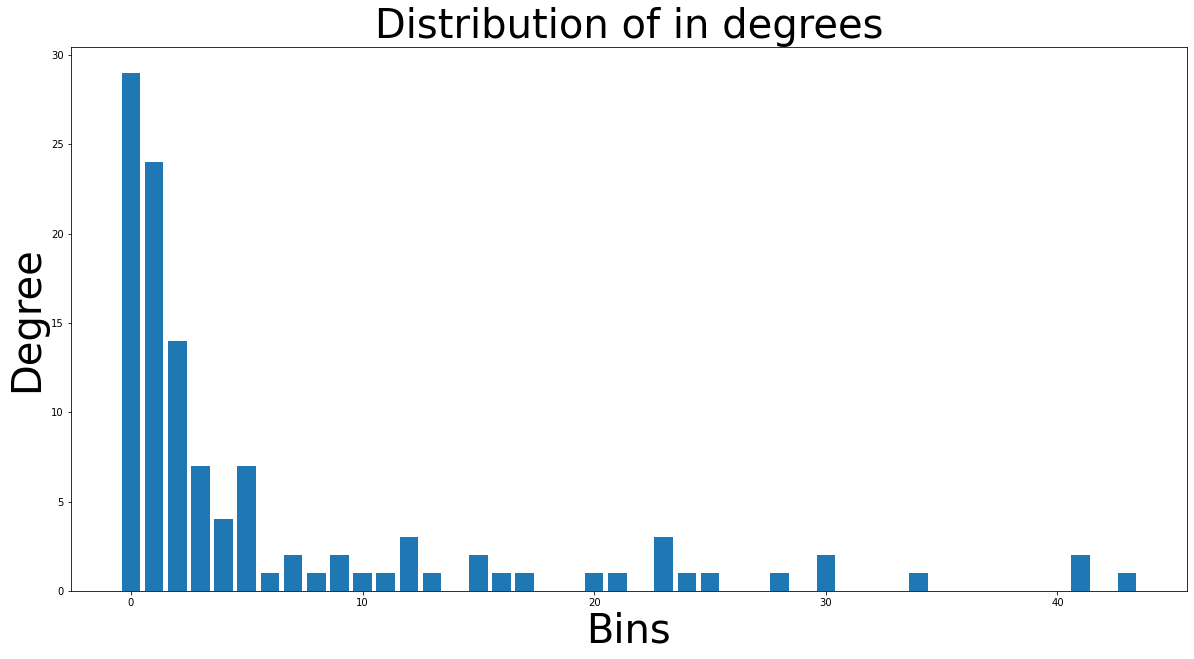

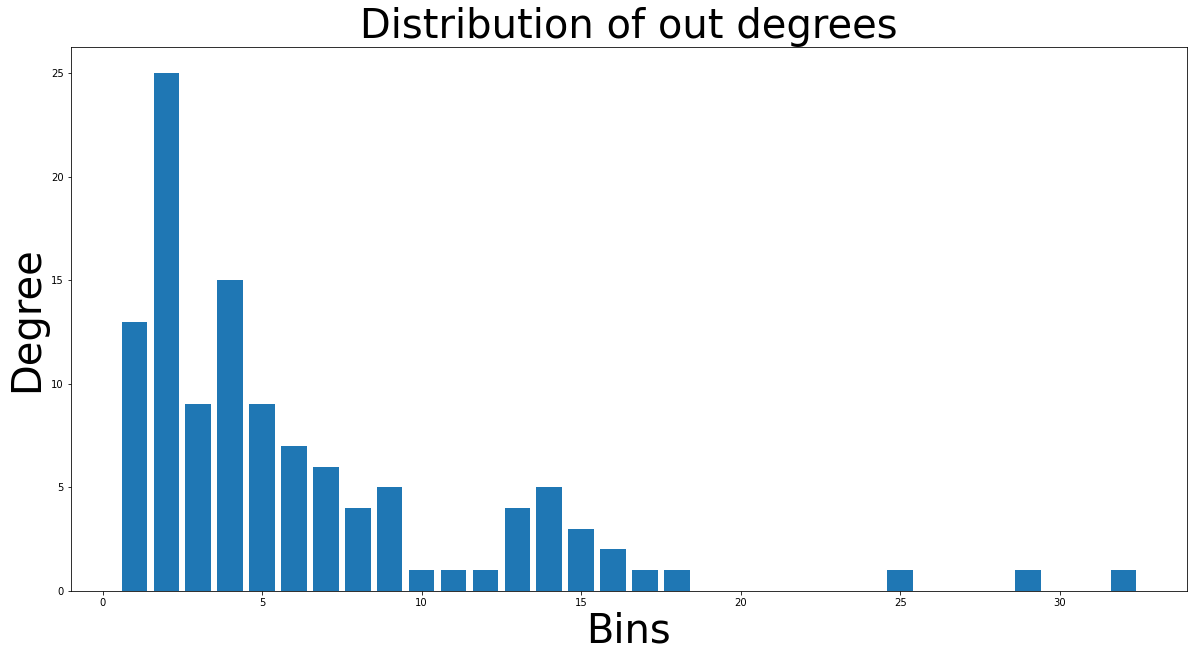

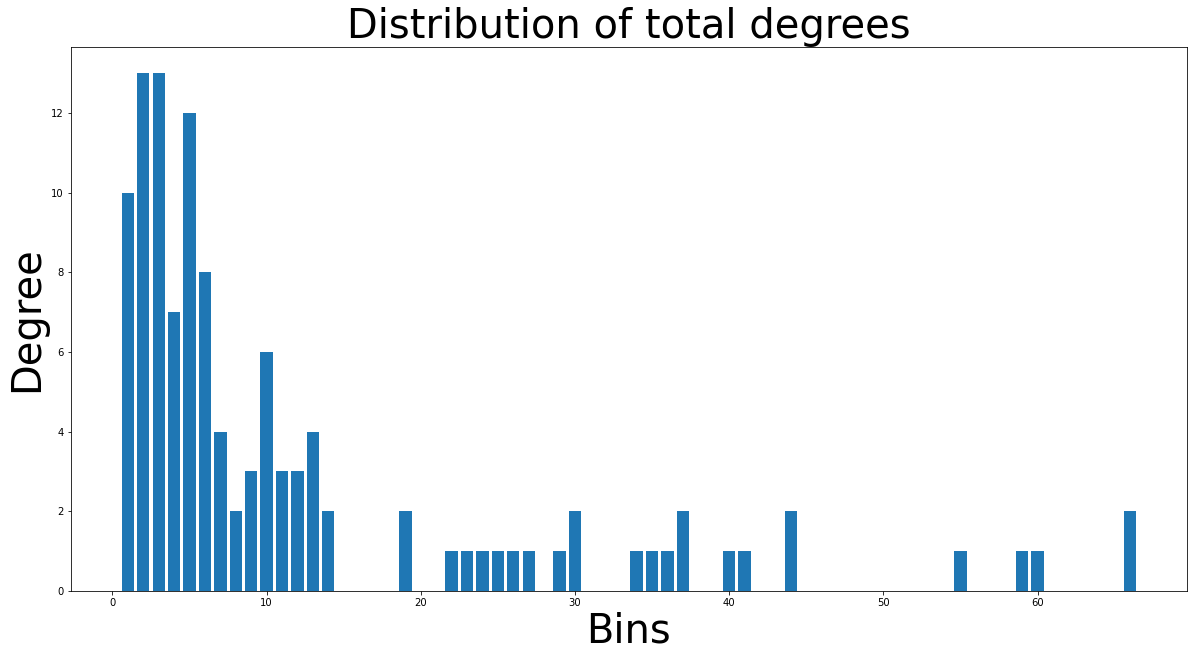

In [289]:
inDegree = [gcc.in_degree(node) for node in gcc.nodes()]
outDegree = [gcc.out_degree(node) for node in gcc.nodes()]
totalDegree = [gcc.degree(node) for node in gcc.nodes()]

maxIn = max(inDegree,key=lambda item:item)
maxOut = max(outDegree,key=lambda item:item)
maxTotal = max(totalDegree,key=lambda item:item)

minIn = min(inDegree,key=lambda item:item)
minOut = min(outDegree,key=lambda item:item)
minTotal = min(totalDegree,key=lambda item:item)
fontSize = 40

vIn = np.linspace(minIn, maxIn, maxIn-minIn+1)
counts, vIn = np.histogram(inDegree, vIn)
plt.figure(figsize=(20,10))
plt.bar(vIn[:-1], counts)
plt.xlabel("Bins", fontsize=fontSize)
plt.ylabel("Degree", fontsize=fontSize)
plt.title('Distribution of in degrees', fontsize=fontSize)

vOut = np.linspace(minOut, maxOut, maxOut-minOut+1)
counts, vOut = np.histogram(outDegree, vOut)
plt.figure(figsize=(20,10))
plt.bar(vOut[:-1], counts)
plt.xlabel("Bins",fontsize=fontSize)
plt.ylabel("Degree",fontsize=fontSize)
plt.title('Distribution of out degrees',fontsize=fontSize)

vTotal = np.linspace(minTotal, maxTotal, maxTotal-minTotal+1)
counts, vTotal = np.histogram(totalDegree, vTotal)
plt.figure(figsize=(20,10))
plt.bar(vTotal[:-1], counts)
plt.xlabel("Bins",fontsize=fontSize)
plt.ylabel("Degree",fontsize=fontSize)
plt.title('Distribution of total degrees',fontsize=fontSize)



In [290]:
# print(gcc.degree)

In [291]:
d = dict(gcc.degree)

# nx.draw(gcc, nodelist=d.keys(), node_size=[(v+1) * 20 for v in d.values()])
# plt.figure(figsize=(20,10))
# plt.show()
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.5,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=100.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(gcc, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:01<00:00, 1047.07it/s]

BarnesHut Approximation  took  0.28  seconds
Repulsion forces  took  1.43  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


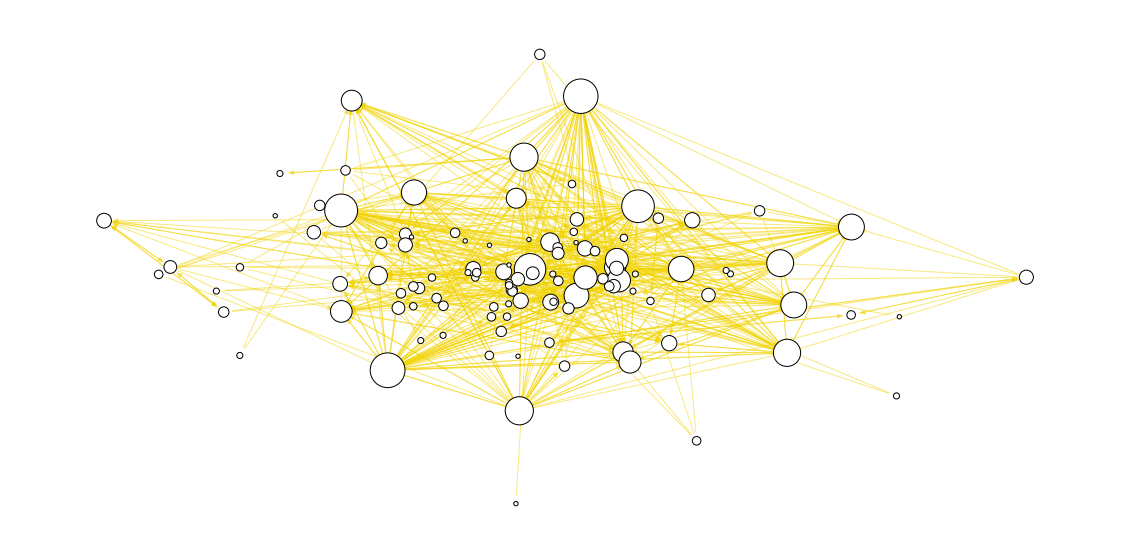

In [292]:
list_degree=list(gcc.degree()) #this will return a list of tuples each tuple is(node,deg)
nodes , degree = map(list, zip(*list_degree)) #build a node list and corresponding degree list


plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(gcc, positions, nodelist=nodes, node_size=[(v * 18)+1 for v in degree], edgecolors="black", node_color= "#ffffff")
nx.draw_networkx_edges(gcc, positions,edge_color = "#F1D302", alpha = 0.5)
plt.axis('off')

plt.show()

In [293]:
cultures1 = [(node[0],node[1]['cultures']) for node in G.nodes(data = True)]
with open('your_file.txt', 'w', encoding='utf-8') as f:
    for item in cultures1:
        f.write(str(item[0]) + ',' + str(item[1]) +  "\n"  )
        # print(type(item))
# print(cultures1)

In [294]:
races1 = [(node[0],node[1]['race']) for node in G.nodes(data = True)]
# print(races1)

In [295]:
races = set()
for node in gcc.nodes(data=True):
    if bool(node[1]):
        races.add(node[1]['race'])
cultures = set()
cultureCount = {}
for node in gcc.nodes(data=True):
    if bool(node[1]):
        for i in node[1]['cultures']:
            cultures.add(i)
raceCount = {}
for item in races:
    raceCount[item] = 0
for item in cultures:
    cultureCount[item] = 0 
genderCount ={'Male':0,'Female':0,'Unknown':0}

for node in gcc.nodes(data=True):
    if bool(node[1]):
        raceCount[node[1]['race']] = raceCount[node[1]['race']] + 1
        genderCount[node[1]['gender']] = genderCount[node[1]['gender']] + 1
        for i in node[1]['cultures']:
            cultureCount[i] = cultureCount[i] + 1

print(cultureCount)
print('------------------------------------------')
print(raceCount)



{'The Faithful': 1, 'Buckland': 2, 'Bracegirdle': 2, 'Bolgers': 1, 'Mordor': 1, 'Nazgûl': 2, 'Unkown': 5, 'Dunlendings': 1, 'Galadhrim': 5, 'Silvan Elves': 5, 'Tooks': 1, 'Haradrim': 1, 'Shire': 20, 'House of Olwë': 1, 'Valaraukar': 1, 'Uruk-hai': 1, 'Maiar': 2, 'Gladden Fields': 1, 'Proudfoot': 2, 'Ñoldor': 2, 'Wood-elves': 2, 'Doriath': 1, 'House of Telcontar': 2, 'Andúnië': 1, 'House of Finarfin': 1, 'House of Isildur': 1, 'Nandor': 2, 'Men of Bree': 3, 'Sindar': 3, 'Gardners': 1, 'Oathbreakers': 1, 'Men of Gondor': 8, 'Lords of Andúnië': 1, 'Aulë': 2, "Durin's Folk": 3, 'Sackville-Baggins': 1, 'Brandybuck': 2, 'Lake-town': 1, 'Númenoreans': 1, 'Rivendell': 3, 'Black Uruks': 1, 'Isengard Orcs': 2, 'House of Húrin': 3, 'Morgul orcs': 1, 'Morannon orcs': 1, 'Sackville-Bagginses': 1, 'Rohirrim': 18, 'Black Númenórean': 1, 'Brandybucks': 1, 'Gamgee': 4, 'Gardner': 1, 'Valinor': 1, 'House of Eorl': 4, 'Dúnedain of Arnor': 1, 'Baggins family': 2, 'Ungoliant': 1, 'Fangorn Forest': 1, 'Fair

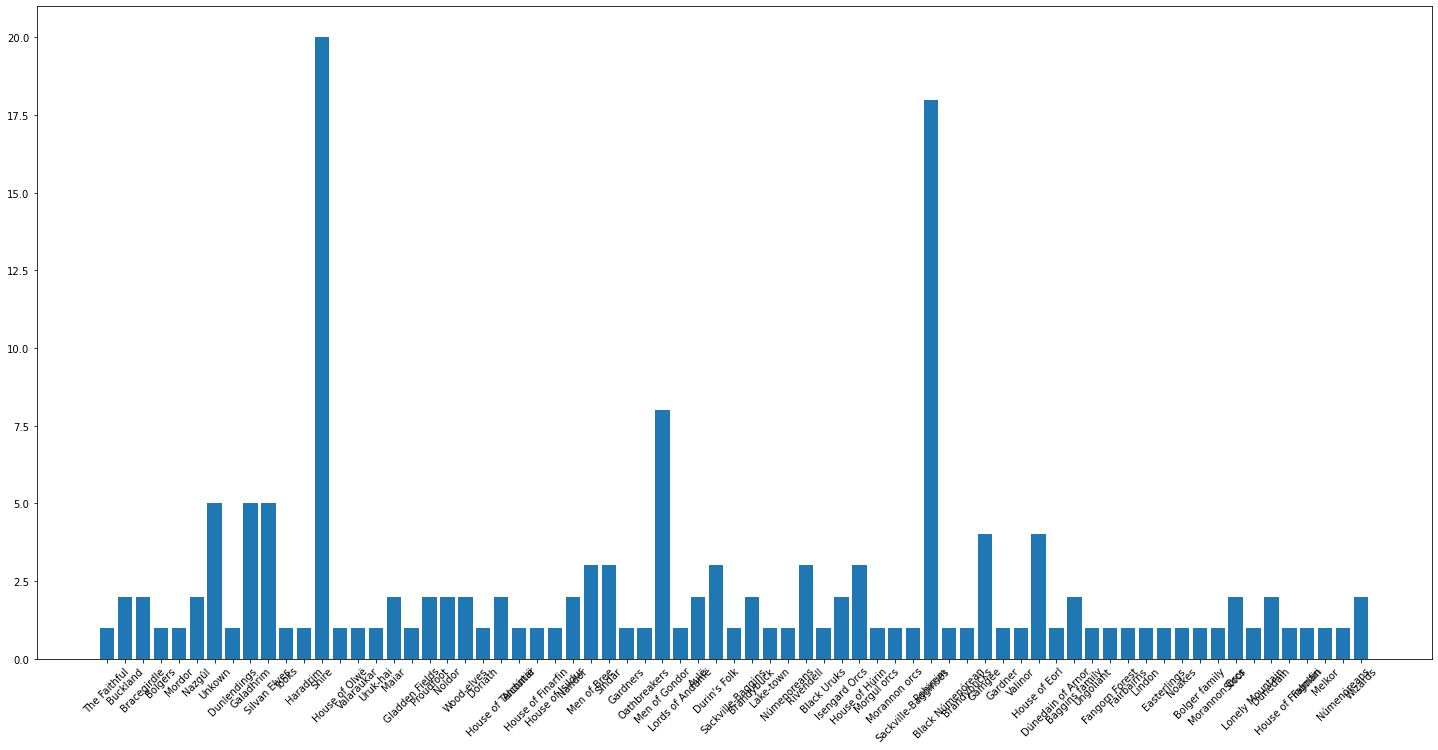

In [296]:
plt.figure(figsize=(25,12))
plt.bar(cultureCount.keys(),cultureCount.values())
plt.xticks(rotation=45)
plt.show()


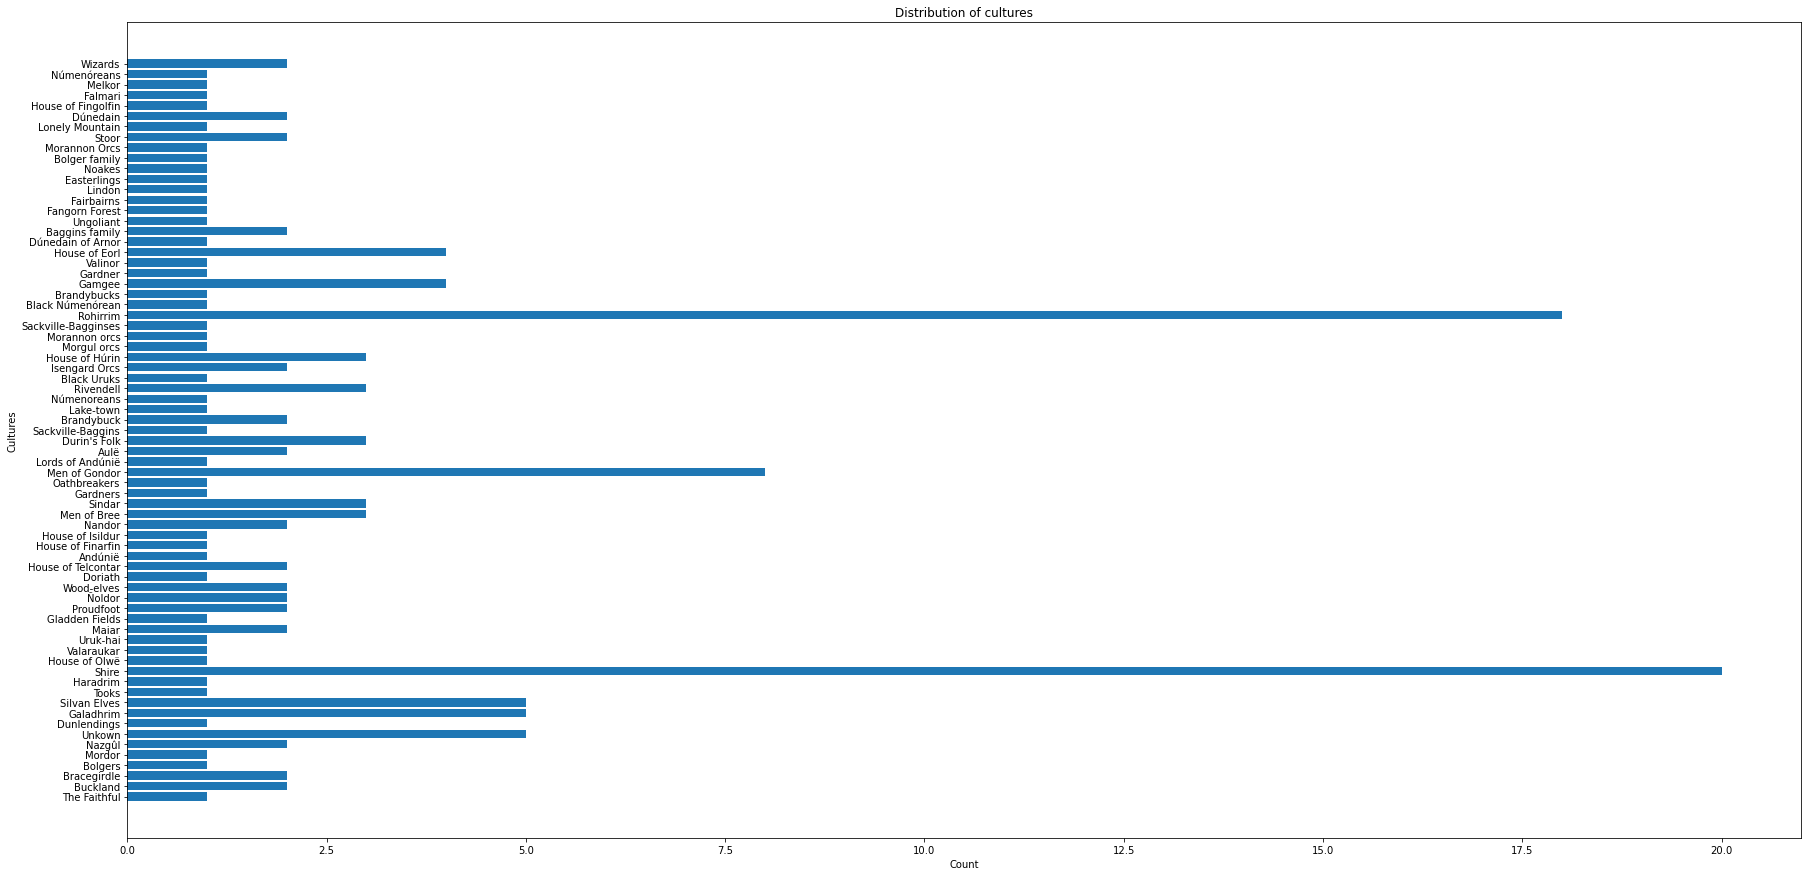

In [297]:
fig,ax = plt.subplots(figsize=(30,15))
ax.barh(list(cultureCount.keys()),cultureCount.values(),align = 'center')
ax.set_xlabel('Count')
ax.set_ylabel('Cultures')
ax.set_title('Distribution of cultures')
# ax.set_xscale('log')
plt.show()

In [298]:
#TODO filtera út spes dót (Elijah Wood,Two towers)

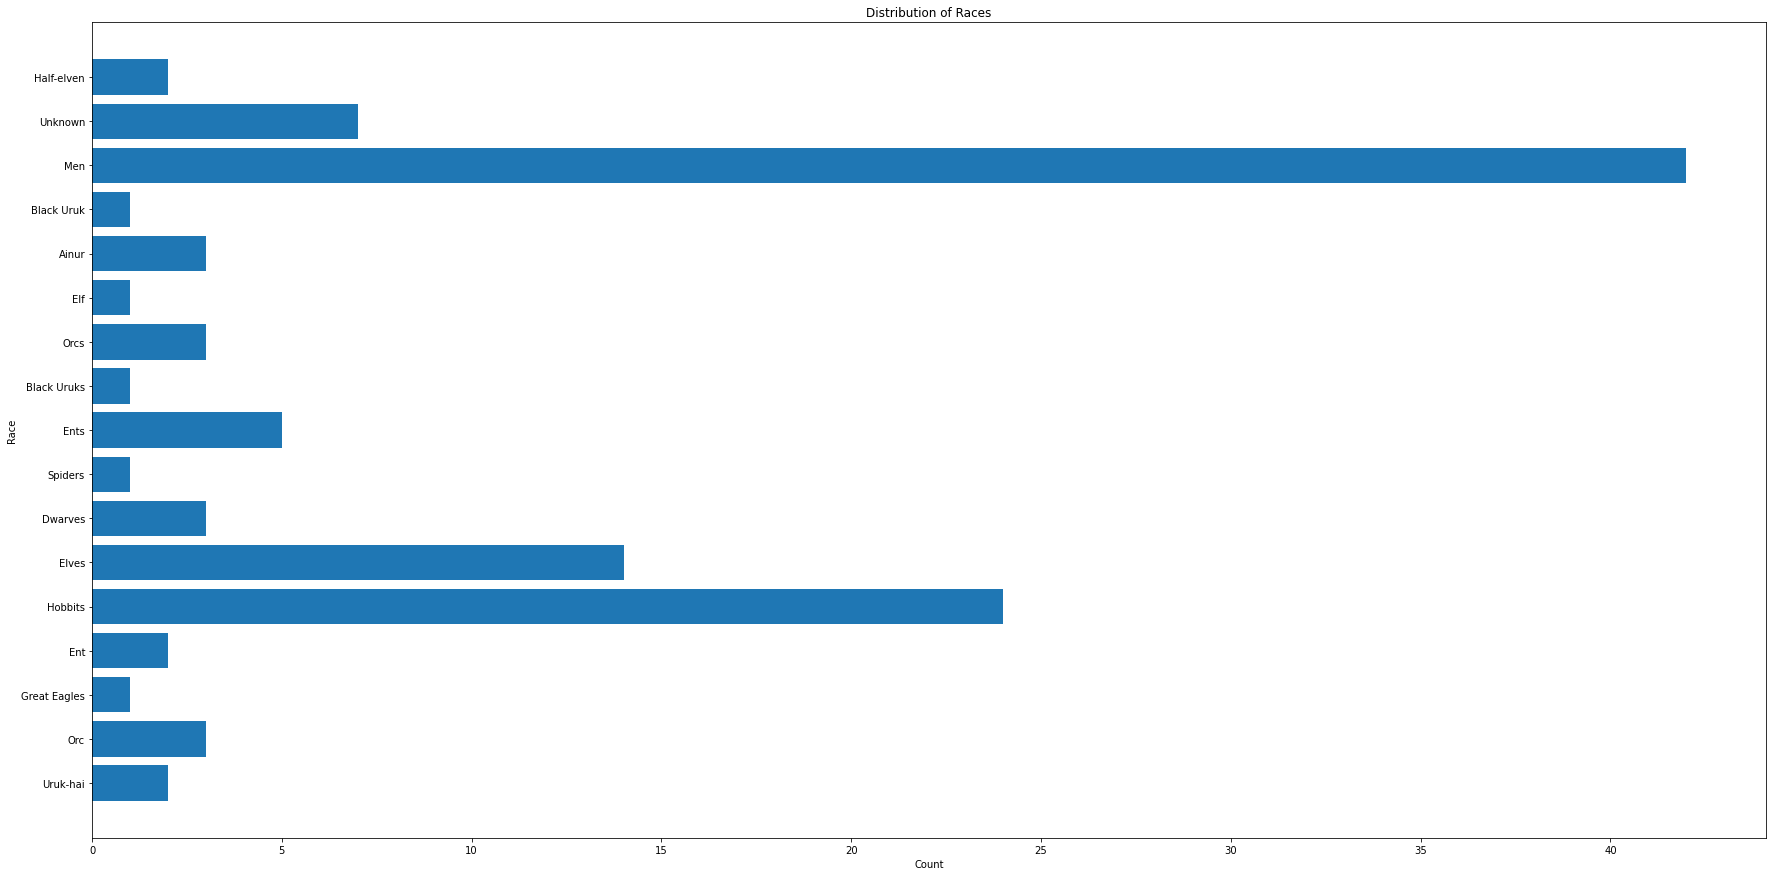

In [299]:
fig,ax = plt.subplots(figsize=(30,15))
ax.barh(list(raceCount.keys()),raceCount.values(),align = 'center')
ax.set_xlabel('Count')
ax.set_ylabel('Race')
ax.set_title('Distribution of Races')
# ax.set_xscale('log')
plt.show()

In [300]:
#TODO SAMEINA EIN OG FLEIRTÖLU (orc/orcs, man/men, hobbit/hobbits)

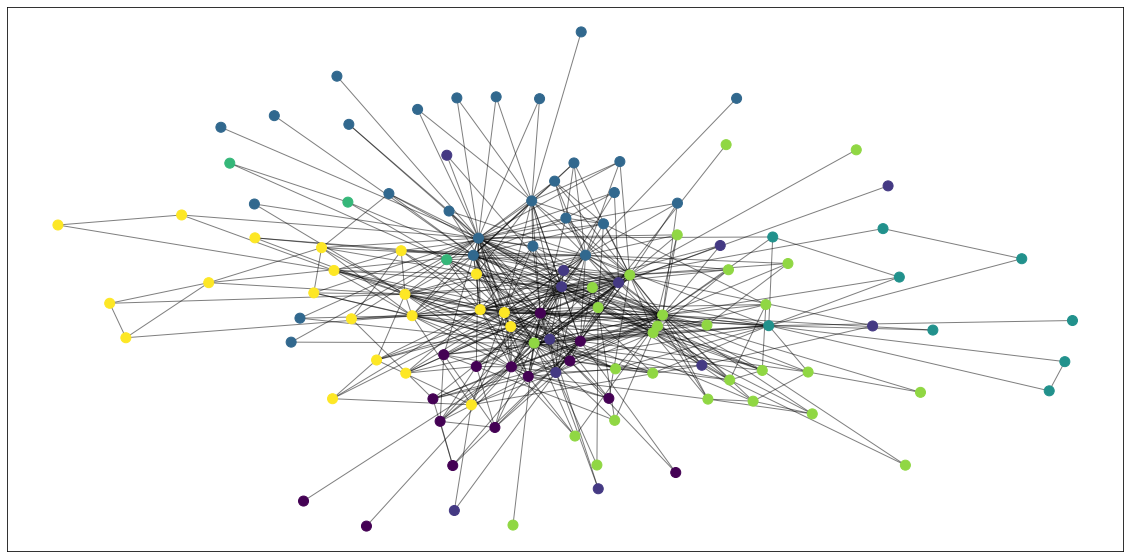

In [301]:
G = gcc.to_undirected()

#computing the best partition
partition = community_louvain.best_partition(G)

all_partitions = list(partition.values())

plt.figure(figsize=(20,10))
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=100, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()
# print(partition)

100%|██████████| 2000/2000 [00:02<00:00, 981.16it/s] 


BarnesHut Approximation  took  0.27  seconds
Repulsion forces  took  1.55  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.07  seconds


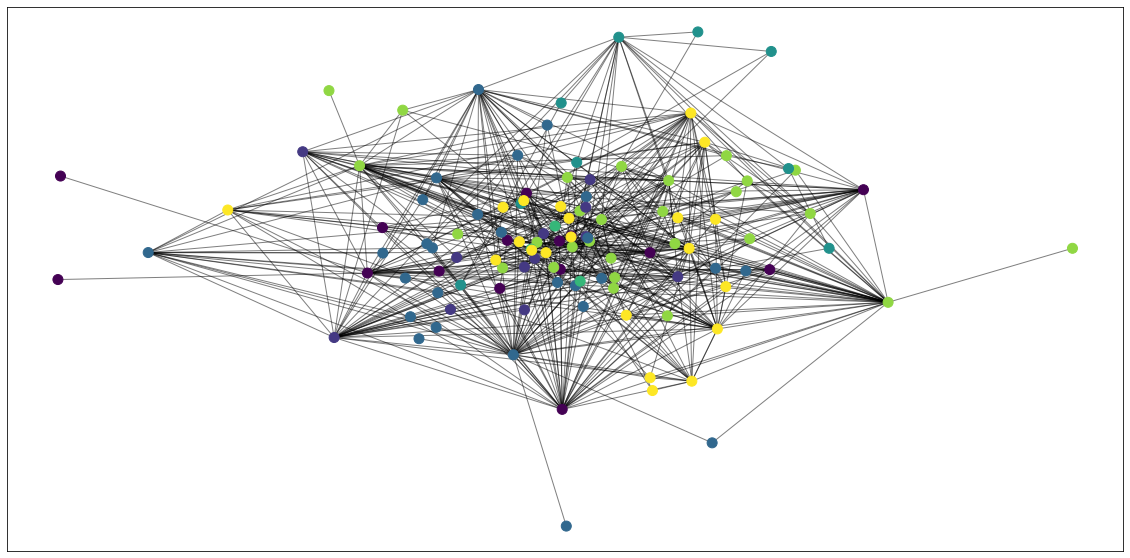

In [302]:
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(G, positions, partition.keys(), node_size=100, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, positions, alpha=0.5)
plt.show()

In [303]:
#A list including all communities
allC = dict(Counter(all_partitions))
sorted_c = dict(sorted(allC.items()))

print("Number of communities: ", len(sorted_c.keys()))
print(allC)

Number of communities:  7
{0: 15, 1: 12, 5: 28, 3: 9, 2: 27, 6: 21, 4: 3}


In [304]:
community_list = []
for i in allC:
    tmp = []
    for key, value in partition.items():        
        if value == i:
            tmp.append(key)
    community_list.append((i,tmp))
print()

## We edited The txt file for frodo baggins, only the format of the file was changed but no content.

This was done so "Elijah Wood" would not be added as a culture.

Shelob text file, removed \<ref\>\<ref\>

In [305]:
# print(G.degree('Saruman'))
sortedDegree = [(node,G.degree(node)) for node in G.nodes()]
sortedDegree.sort(key=lambda y: y[1],reverse=True)
print(sortedDegree)

[('Saruman', 48), ('Frodo Baggins', 45), ('Sauron', 43), ('Aragorn II Elessar', 41), ('Gandalf', 36), ('Peregrin Took', 33), ('Meriadoc Brandybuck', 32), ('Gimli', 30), ('Galadriel', 28), ('Legolas', 28), ('Éomer', 27), ('Elrond', 26), ('Théoden', 25), ('Samwise Gamgee', 24), ('Gollum', 22), ('Bilbo Baggins', 20), ('Faramir', 20), ('Boromir', 19), ('Éowyn', 19), ('Witch-king of Angmar', 19), ('Arwen', 18), ('Treebeard', 18), ('Celeborn', 17), ('Gríma Wormtongue', 14), ('Isildur', 11), ('Denethor II', 11), ('Uglúk', 10), ('Háma', 10), ('Watcher in the Water', 9), ('Mouth of Sauron', 9), ('Círdan', 9), ('Shelob', 9), ('Gwaihir', 9), ('Grishnákh', 9), ('Haldir of Lothlórien', 9), ('Gothmog (Lieutenant of Morgul)', 9), ('Gamling', 9), ('Elendil', 8), ('Glóin', 8), ('Shagrat', 8), ('Théodred', 8), ('Eldarion', 7), ("Durin's Bane", 7), ('Gil-galad', 7), ('Snaga (Isengard)', 7), ('Murgash', 7), ('Rosie Cotton', 6), ('Elanor Gardner', 6), ('Balin', 6), ('Hamfast Gamgee', 6), ('Figwit', 6), ('G

In [306]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap

In [307]:
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='degree', values=degrees)

In [308]:
number_to_adjust_by = 5
adjusted_node_size = dict([(node, degree+number_to_adjust_by) for node, degree in nx.degree(G)])
nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

In [314]:
# Create empty dictionaries
modularity_color = {}
#Loop through each community in the network
for member, community in partition.items():
    #For each member of the community, add their community number and a distinct color
    modularity_color[member] = Viridis8[community]

In [312]:
#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'modularity_color'
#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Viridis8
#Choose a title!
title = 'Lord of the Rings Network'

nx.set_node_attributes(G, name='community', values=partition)
nx.set_node_attributes(G, modularity_color, 'modularity_color')


#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("Character", "@index"),
        ("Degree", "@degree"),
         ("Community", "@community"),
         ("Race","@race"),
         ("Cultures","@cultures")
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset, tap", active_scroll='wheel_zoom',
            x_range=Range1d(-45.1, 40.1), y_range=Range1d(-40.1, 40.1), title=title)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G, positions, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

plot.renderers.append(network_graph)

show(plot)
save(plot, filename="LortNetwork.html")

C:\Users\jonah\Anaconda3\lib\site-packages\bokeh\io\saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
C:\Users\jonah\Anaconda3\lib\site-packages\bokeh\io\saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'c:\\Users\\jonah\\Social Graphs\\Github\\DataQueens\\Project\\LortNetwork.html'

In [ ]:
# display(HTML('LortNetwork.Html'))
#Works with jupyter viewer in browser, not in VsCode
IFrame(src='/LortNetwork.html', width=700, height=600)

